# <center>Задача 5. Обучение без учителя</center>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans as SklearnKMeans, DBSCAN, AffinityPropagation
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics.pairwise import euclidean_distances
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

%precision %.4f
sns.set(rc={'figure.figsize':(20, 10)})
     

Возьмём данные о хобби 4 разных групп людей, которые можно скачать https://www.kaggle.com/datasets/rainbowgirl/clustering-categorical-peoples-interests/data.

Описание датасета: <br>

* group - group name (I, P, C, R) <br>
* grand_tot_interests - Total number of interests they like from the 217 <br>
* interest1 - interest 1 (example: do you like chess? Y/N) <br>
* interest2 - interest 2 (example: do you like swlm? Y/N) <br>
* ...  <br>
* interest217 - interest 217 <br>


Необходимо проверить, можно ли разделить данные на кластеры и совпадают ли получившиеся клсатеры с группами людей.

## Чтение данных

In [2]:
df = pd.read_csv('kaggle_Interests_group.csv')
df

,group,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,...,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
0,C,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C,43,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
2,C,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
3,C,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN
4,C,36,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,I,53,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN
6336,I,48,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
6337,I,48,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
6338,I,38,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN


# Основные статистики датасета

In [3]:
df.describe()

,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,interest9,...,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
count,6340.000000,993.0,1.0,35.0,25.0,798.000000,3394.000000,1.0,93.0,333.000000,...,118.000000,110.0,5037.000000,2474.000000,877.000000,2.0,72.0,4943.000000,4058.000000,147.0
mean,37.312303,1.0,1.0,1.0,1.0,1.001253,1.000589,1.0,1.0,1.003003,...,1.008475,1.0,1.000596,1.000808,1.002281,1.0,1.0,1.000202,1.000246,1.0
std,15.729872,0.0,NaN,0.0,0.0,0.035400,0.024271,NaN,0.0,0.054800,...,0.092057,0.0,0.024400,0.028427,0.047727,0.0,0.0,0.014223,0.015698,0.0
min,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
25%,28.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
50%,39.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
75%,48.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
max,104.000000,1.0,1.0,1.0,1.0,2.000000,2.000000,1.0,1.0,2.000000,...,2.000000,1.0,2.000000,2.000000,2.000000,1.0,1.0,2.000000,2.000000,1.0


In [4]:
# выведем различные значения в каждой колонке
for col in df:
    print(df[col].unique())

['C' 'P' 'R' 'I']
[ 17  43  27  34  36   6  54   2  29  44  39  28  47  38  37  11  71  48
   4   1  60  23  24  45  30  51  22   8  10  57  26  41  13  46  31  25
  62  32  56  42  49  55   3  66  58  21  70  35  61  40  63  69  52  59
  50  33   9  53  65  64  18  15  20  19  16  81  75  14  12  73  97   7
  76  74   5  68  89  67  80 104  84  82  77  72  99]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[ 1. nan  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[ 1. nan  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[ 1. nan  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[ 1. nan  2.]
[nan  1.  2.]
[nan  1.]
[nan  1.  2.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[nan  1.]
[ 1. nan  2.]
[ 1. nan  2.]


Можем видеть, что есть как очень редкие интересы, встречающиеся только у одного человека, так и очень распространённые. 
Так же есть строки в которых наличие данного интереса имеет значение не 1, а 2. Заменим все такие значения на 1 и преобразуем NaN в 0.

In [5]:
df.iloc[:, 2:] = df.iloc[:, 2:].applymap(lambda x: 0 if pd.isnull(x) else (1 if x != 1 else 1))
df.describe()

,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,interest9,...,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
count,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,...,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000
mean,37.312303,0.156625,0.000158,0.005521,0.003943,0.125868,0.535331,0.000158,0.014669,0.052524,...,0.018612,0.017350,0.794479,0.390221,0.138328,0.000315,0.011356,0.779653,0.640063,0.023186
std,15.729872,0.363475,0.012559,0.074101,0.062676,0.331726,0.498789,0.012559,0.120233,0.223098,...,0.135161,0.130583,0.404113,0.487838,0.345271,0.017760,0.105968,0.414513,0.480019,0.150506
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,104.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
print(df.head())

  group  grand_tot_interests  interest1  interest2  interest3  interest4  \
0     C                   17        0.0        0.0        0.0        0.0   
1     C                   43        1.0        0.0        0.0        0.0   
2     C                   27        0.0        0.0        0.0        0.0   
3     C                   34        0.0        0.0        0.0        0.0   
4     C                   36        0.0        0.0        0.0        0.0   

   interest5  interest6  interest7  interest8  ...  interest208  interest209  \
0        0.0        0.0        0.0        0.0  ...          0.0          0.0   
1        1.0        0.0        0.0        0.0  ...          0.0          0.0   
2        0.0        0.0        0.0        0.0  ...          0.0          0.0   
3        0.0        0.0        0.0        0.0  ...          0.0          0.0   
4        1.0        0.0        0.0        0.0  ...          0.0          0.0   

   interest210  interest211  interest212  interest213  interes

In [7]:
initial_shape = df.shape[0]  # Количество строк до удаления дубликатов
df = df.drop_duplicates()
new_shape = df.shape[0]  # Количество строк после удаления дубликатов
print(df.shape)
print(f"Было удалено {initial_shape - new_shape} дубликатов.")

(6181, 219)
Было удалено 159 дубликатов.


## EDA

In [8]:
df.group.value_counts()

group
I    1780
P    1697
C    1662
R    1042
Name: count, dtype: int64

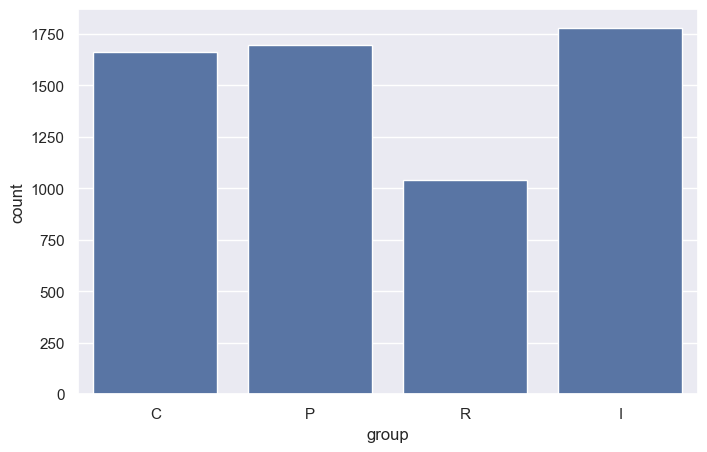

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='group', data=df)
plt.show()

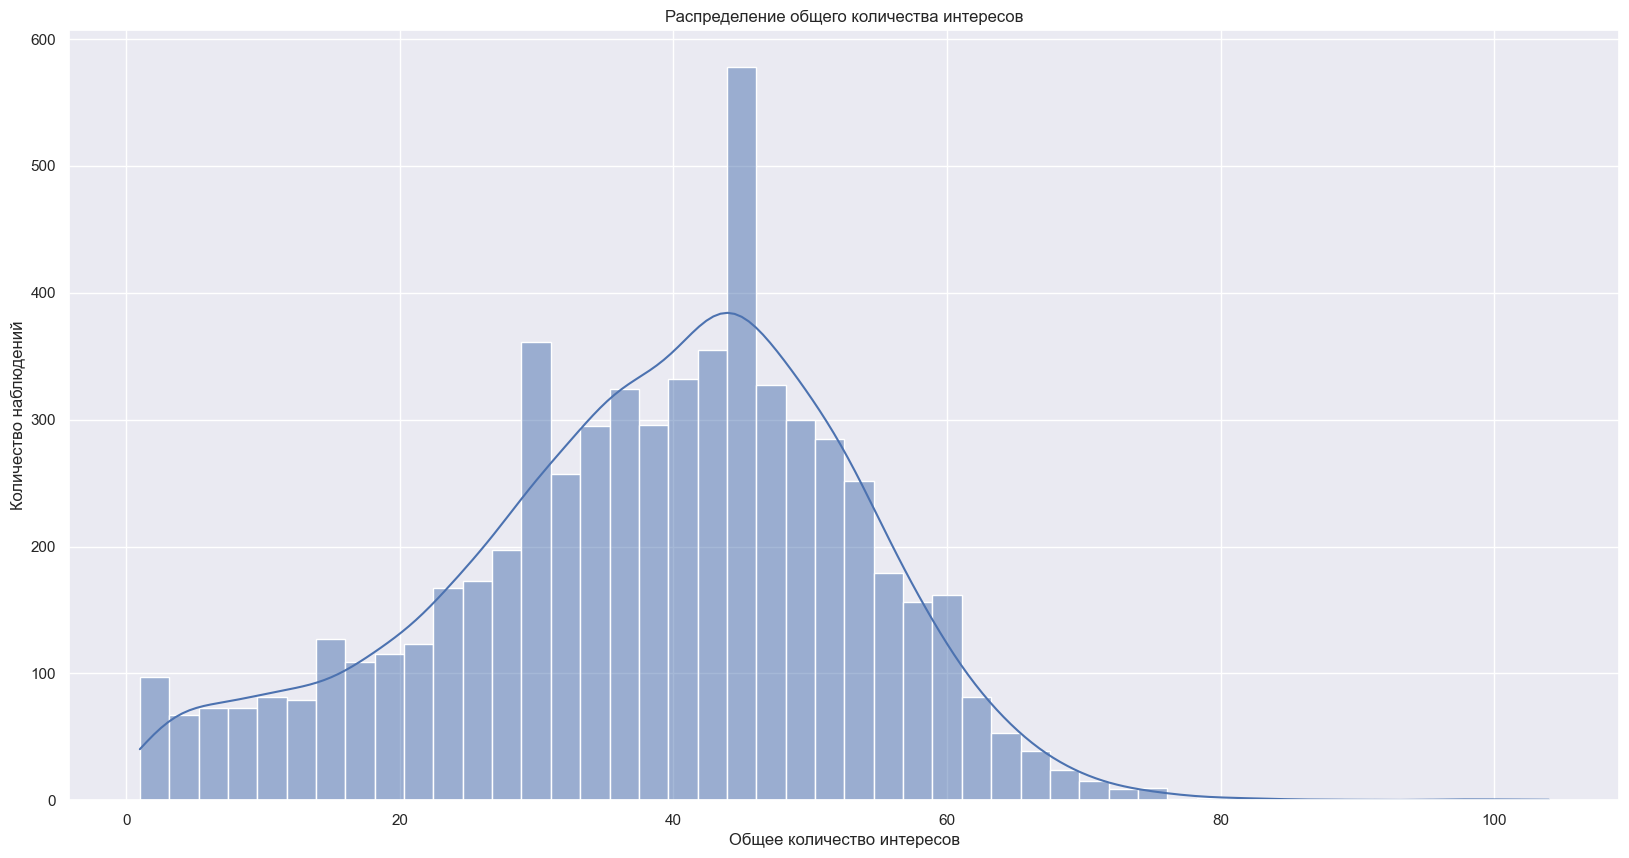

In [10]:
# Распределение общего количества интересов
sns.histplot(df['grand_tot_interests'], kde=True)
plt.title('Распределение общего количества интересов')
plt.xlabel('Общее количество интересов')
plt.ylabel('Количество наблюдений')
plt.show()

In [11]:
df.groupby('group').mean()

,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,interest9,...,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
group,,,,,,,,,,,,,,,,,,,,,
C,37.116727,0.168472,0.000000,0.010229,0.006017,0.183514,0.516847,0.000000,0.014440,0.050542,...,0.019856,0.039110,0.767750,0.291215,0.116727,0.000602,0.036703,0.755114,0.599880,0.028881
I,41.396629,0.184831,0.000562,0.004494,0.003371,0.126966,0.579775,0.000000,0.020787,0.056742,...,0.015169,0.010674,0.858427,0.455056,0.176966,0.000562,0.002247,0.868539,0.755618,0.010674
P,36.361815,0.118444,0.000000,0.002357,0.002357,0.111373,0.523276,0.000589,0.011196,0.039481,...,0.021214,0.006482,0.819093,0.496759,0.144962,0.000000,0.002946,0.795522,0.671184,0.024160
R,37.527831,0.175624,0.000000,0.005758,0.004798,0.074856,0.590211,0.000000,0.012476,0.077735,...,0.021113,0.014395,0.809021,0.323417,0.117083,0.000000,0.001919,0.760077,0.553743,0.037428


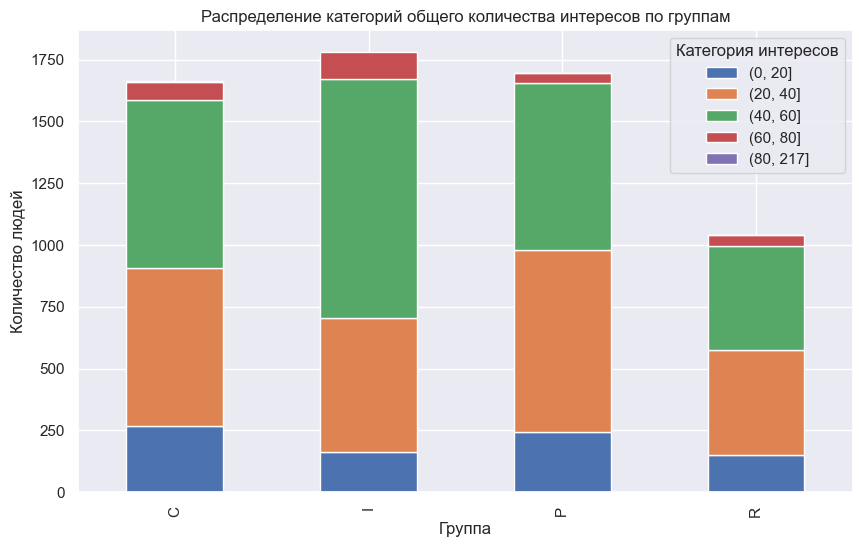

In [12]:
# Категоризация общего количества интересов для упрощения визуализации
df_interests_category = pd.cut(df['grand_tot_interests'], bins=[0, 20, 40, 60, 80, 217])

# Создание кросс-таблицы
interests_category_group_crosstab = pd.crosstab(df['group'], df_interests_category)

# Визуализация с помощью столбчатой диаграммы
interests_category_group_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Распределение категорий общего количества интересов по группам')
plt.xlabel('Группа')
plt.ylabel('Количество людей')
plt.legend(title='Категория интересов')
plt.show()

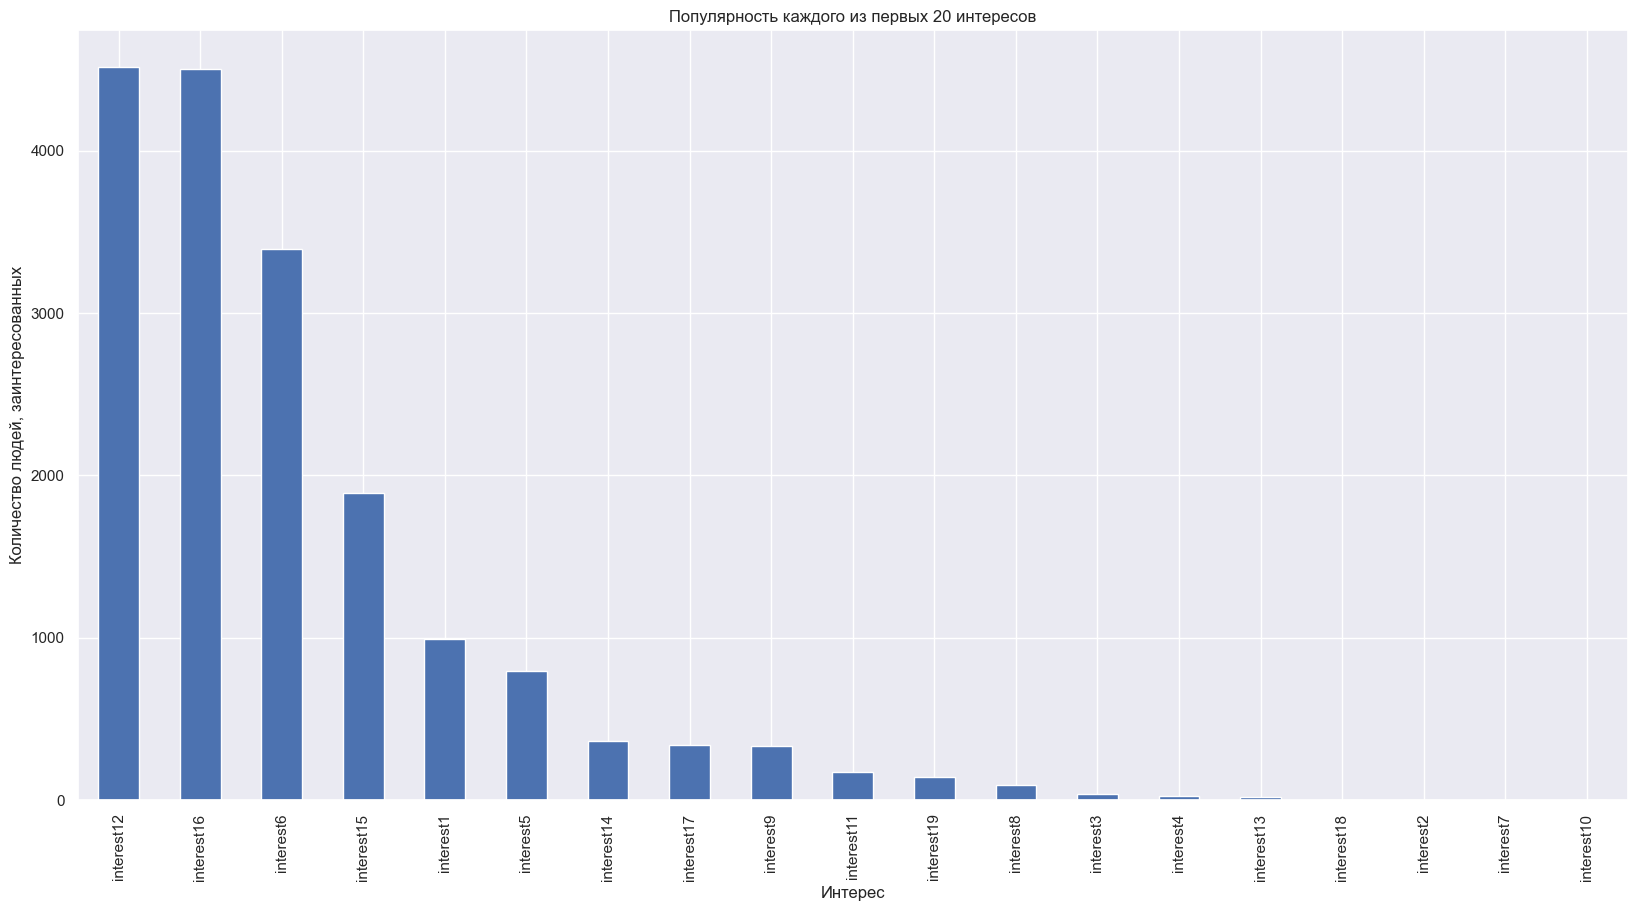

In [13]:
# Как часто встречается каждый интерес (для первых 20)
interest_cols = [f'interest{i}' for i in range(1, 20)]

interests_summary = df[interest_cols].sum().sort_values(ascending=False)
interests_summary.plot(kind='bar')
plt.title('Популярность каждого из первых 20 интересов')
plt.xlabel('Интерес')
plt.ylabel('Количество людей, заинтересованных')
plt.show()

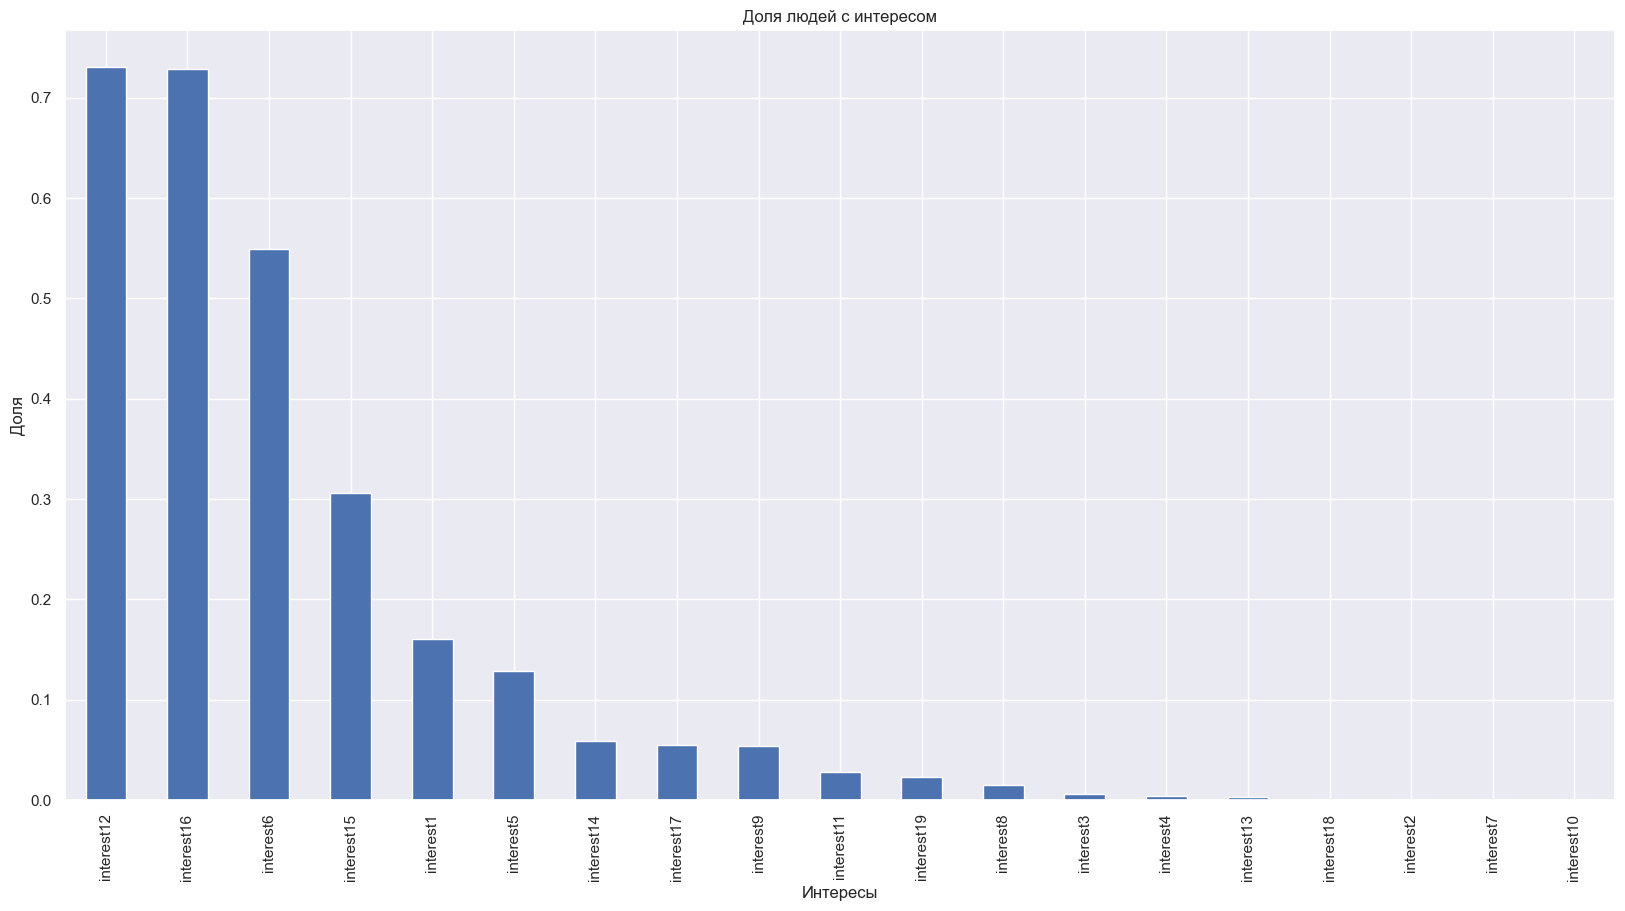

In [14]:
# в процентном соотношении
interest_proportions = df[interest_cols].sum().sort_values(ascending=False) / len(df)
interest_proportions.plot(kind='bar')
plt.title('Доля людей с интересом')
plt.xlabel('Интересы')
plt.ylabel('Доля')
plt.xticks(rotation=90)
plt.show()

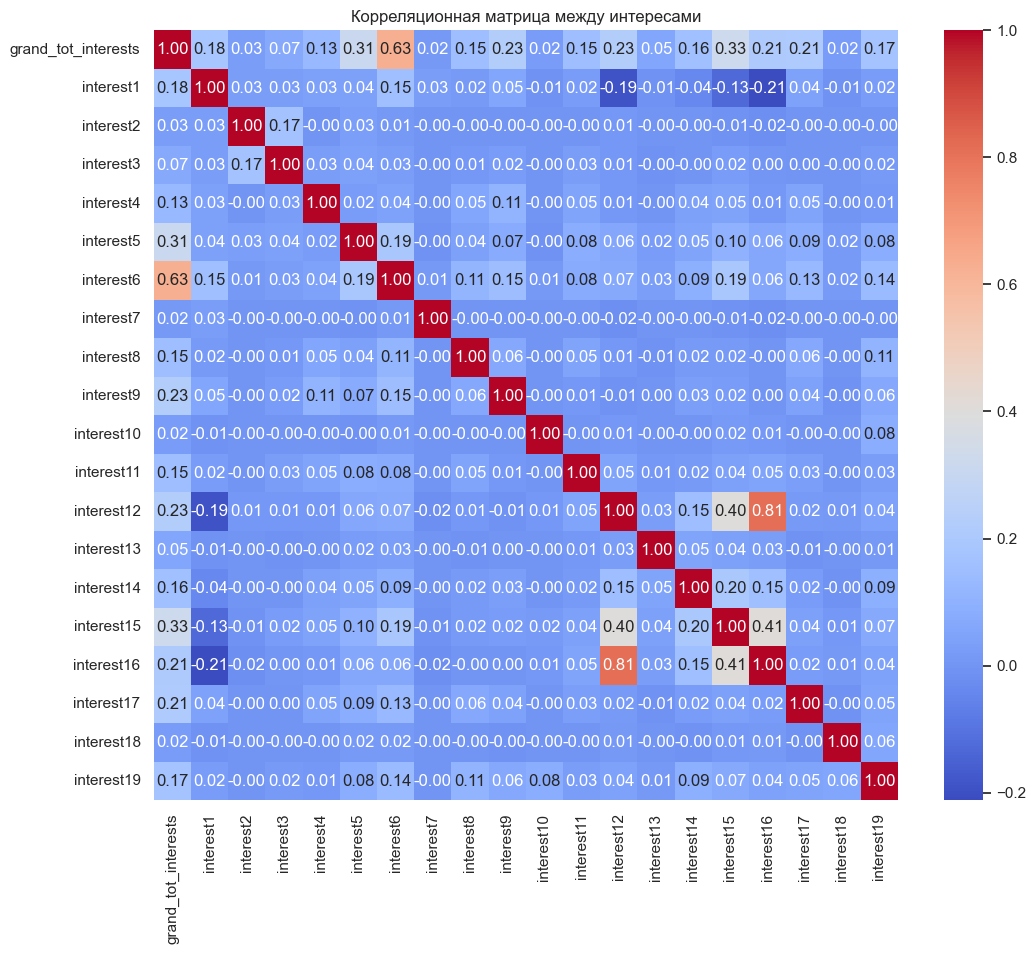

In [15]:
# Рассчитываем корреляцию
correlations = df[['grand_tot_interests'] + interest_cols].corr()

# Визуализация корреляции
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Корреляционная матрица между интересами')
plt.show()

## Data Cleaning


In [16]:
# поиск столбцов с пропущенными значениями (их нет)
zero_sum = df.isnull().sum()
columns_to_drop = zero_sum[zero_sum > 0].index
len(columns_to_drop)


0

In [17]:
# Рассчитываем долю значений, равных 0, для каждого столбца
zero_ratio = (df == 0).sum() / len(df)

# Определяем столбцы, где доля значений, равных 0, превышает 90%
columns_to_drop = zero_ratio[zero_ratio > 0.9].index

# Удаляем эти столбцы из DataFrame
df = df.drop(columns=columns_to_drop)
df.shape

(6181, 75)

остается 75 столбцов

## Переименуем группы

In [18]:
df['group'] = df['group'].map({'C':0,'P':1,'R':2,'I':3})
df

,group,grand_tot_interests,interest1,interest5,interest6,interest12,interest15,interest16,interest21,interest40,...,interest189,interest196,interest200,interest201,interest202,interest210,interest211,interest212,interest215,interest216
0,0,17,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,43,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0,27,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,0,34,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0,36,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,3,53,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
6336,3,48,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
6337,3,48,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
6338,3,38,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
df.describe()

,group,grand_tot_interests,interest1,interest5,interest6,interest12,interest15,interest16,interest21,interest40,...,interest189,interest196,interest200,interest201,interest202,interest210,interest211,interest212,interest215,interest216
count,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,...,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000,6181.000000
mean,1.475651,38.211293,0.160654,0.129105,0.549102,0.730626,0.306099,0.728846,0.662352,0.288626,...,0.561721,0.112765,0.537615,0.270345,0.265167,0.814917,0.400259,0.141886,0.799709,0.656528
std,1.167632,14.882768,0.367241,0.335344,0.497623,0.443670,0.460909,0.444591,0.472946,0.453161,...,0.496216,0.316331,0.498623,0.444174,0.441458,0.388397,0.489990,0.348962,0.400251,0.474906
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,40.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,3.000000,49.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,3.000000,104.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
x=df.drop('group',axis=1).values 
y=df['group'].values


## k-means

In [22]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.inertia_ = self.compute_sse(X, self.labels, self.centroids)
        
    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)

## Обучение и подбор гиперпараметров

Наибольший Silhouette Score (0.52) был достигнут при использовании 2 кластеров, что указывает на то, что объекты внутри кластеров относительно близко расположены друг к другу, а кластеры хорошо разделены.
Минимальный Davies-Bouldin Index (0.67) также наблюдается при 2 кластерах. Поскольку для этого индекса лучшими считаются более низкие значения, результаты подтверждают, что 2 кластера обеспечивают лучшее сочетание компактности кластеров и их разделения.
Стоит отметить, что Calinski-Harabasz Index продолжает расти и достигает максимума при 4 кластерах, что может указывать на более высокую детализацию структуры данных при увеличении количества кластеров.

In [23]:
# Инициализируем и обучаем наш KMeans
best_n_clusters = None
best_silhouette = -1
best_davies_bouldin = float('inf')  # Инициализируем как бесконечность, так как ищем минимум
best_calinski_harabasz = -1
best_model = None

for n_clusters in range(2, 11):  # диапазон кластеров
    model = KMeans(n_clusters=n_clusters)
    model.fit(x)
    labels = model.labels
    
    silhouette_avg = silhouette_score(x, labels)
    davies_bouldin = davies_bouldin_score(x, labels)
    calinski_harabasz = calinski_harabasz_score(x, labels)
    
    print(f"Для n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg}, Davies-Bouldin Index = {davies_bouldin}, Calinski-Harabasz Index = {calinski_harabasz}")
    
    # Предполагаем, что лучшей моделью будет та, у которой лучший Silhouette Score
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_davies_bouldin = davies_bouldin
        best_calinski_harabasz = calinski_harabasz
        best_n_clusters = n_clusters
        best_model = model

print(f"Лучшее количество кластеров: {best_n_clusters}, с Silhouette Score: {best_silhouette}, Davies-Bouldin Index: {best_davies_bouldin}, Calinski-Harabasz Index: {best_calinski_harabasz}")

Для n_clusters = 2, Silhouette Score = 0.5182105393063701, Davies-Bouldin Index = 0.6699183151394837, Calinski-Harabasz Index = 10321.25251942999
Для n_clusters = 3, Silhouette Score = 0.4490663682471745, Davies-Bouldin Index = 0.6979824501512666, Calinski-Harabasz Index = 11635.230062484428
Для n_clusters = 4, Silhouette Score = 0.41534876061132736, Davies-Bouldin Index = 0.7247810335587725, Calinski-Harabasz Index = 12569.552700211474
Для n_clusters = 5, Silhouette Score = 0.37045124660933276, Davies-Bouldin Index = 0.7985406273621557, Calinski-Harabasz Index = 12626.701174624794
Для n_clusters = 6, Silhouette Score = 0.343552786390614, Davies-Bouldin Index = 0.8381572966826624, Calinski-Harabasz Index = 12065.960786450065
Для n_clusters = 7, Silhouette Score = 0.31386390139872944, Davies-Bouldin Index = 0.8985202656119216, Calinski-Harabasz Index = 11139.315208628597
Для n_clusters = 8, Silhouette Score = 0.2990614395316313, Davies-Bouldin Index = 0.9535648868662914, Calinski-Haraba

#### Рассмотрим вариант с 4 кластерами и сопоставим с реальными группами людей
А так же замерим скорость обучения

Sklearn KMeans время обучения: 0.06959104537963867 секунд


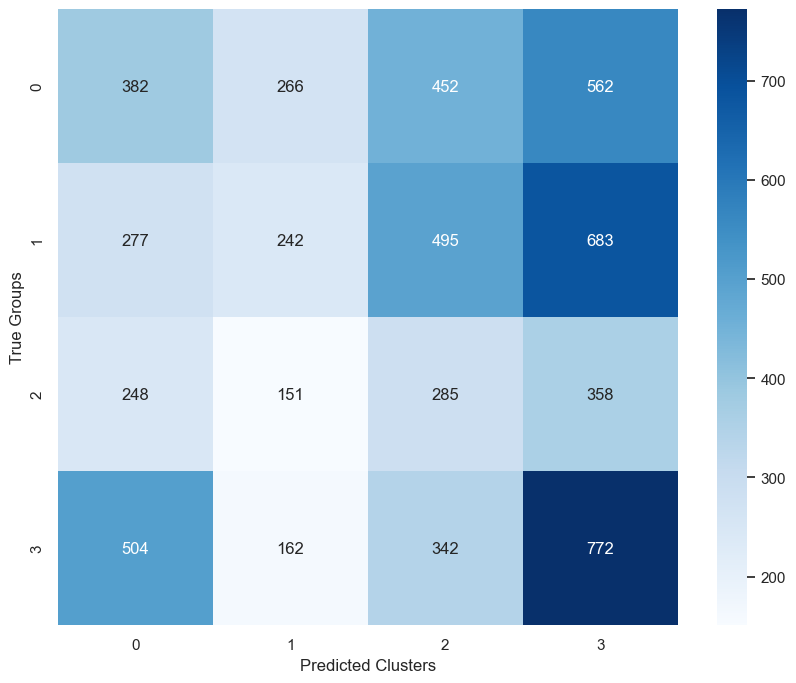

In [24]:
start_time = time.time()
custom_kmeans = KMeans(n_clusters=4)
custom_kmeans.fit(x)
print(f"Sklearn KMeans время обучения: {time.time() - start_time} секунд")
conf_matrix = confusion_matrix(y, custom_kmeans.labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Groups')
plt.show()

In [25]:
ari = adjusted_rand_score(y, custom_kmeans.labels)
ami = adjusted_mutual_info_score(y, custom_kmeans.labels)
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, custom_kmeans.labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Adjusted Mutual Information: {ami:.4f}")
print(f"Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

Adjusted Rand Index: 0.0098
Adjusted Mutual Information: 0.0093
Homogeneity: 0.0097, Completeness: 0.0100, V-measure: 0.0098


Полученные значения метрик качества кластеризации указывают на очень низкое согласие между исходными группами и результатами кластеризации.

#### Рассмотрим вариант с 2 кластерами и сопоставим с реальными группами людей

Sklearn KMeans время обучения: 0.07986807823181152 секунд


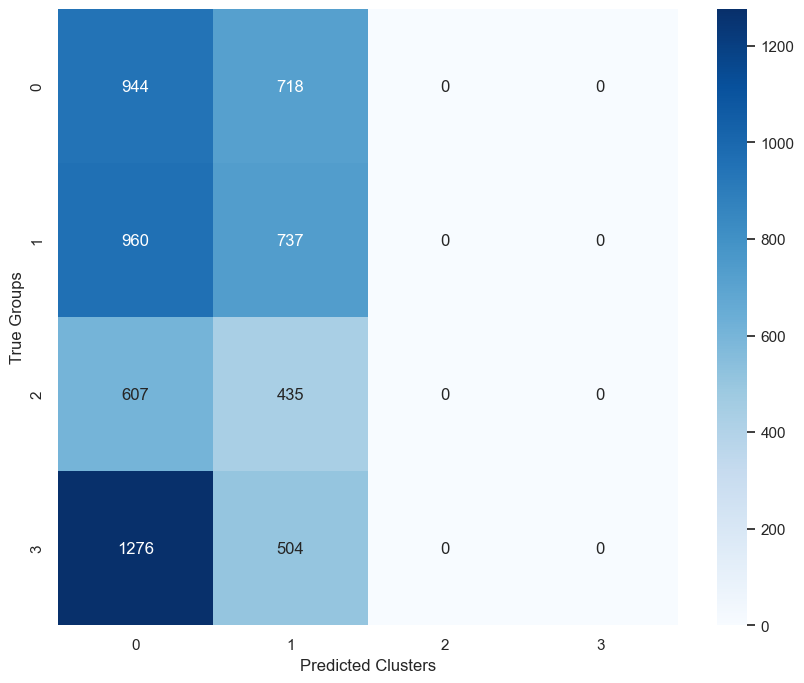

In [27]:
start_time = time.time()
custom_kmeans = KMeans(n_clusters=2)
custom_kmeans.fit(x)
print(f"Sklearn KMeans время обучения: {time.time() - start_time} секунд")
conf_matrix = confusion_matrix(y, custom_kmeans.labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Groups')
plt.show()

С двумя кластерами ситуация аналогичная.

In [28]:
ari = adjusted_rand_score(y, custom_kmeans.labels)
ami = adjusted_mutual_info_score(y, custom_kmeans.labels)
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, custom_kmeans.labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Adjusted Mutual Information: {ami:.4f}")
print(f"Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

Adjusted Rand Index: 0.0112
Adjusted Mutual Information: 0.0092
Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094


inertia =  [542240.6336420228, 303773.41827455274, 203440.40970730814, 157441.37595978728, 128607.59567605014, 112471.05783994833, 101024.77195957748, 93381.35790786505, 87082.81977405072]


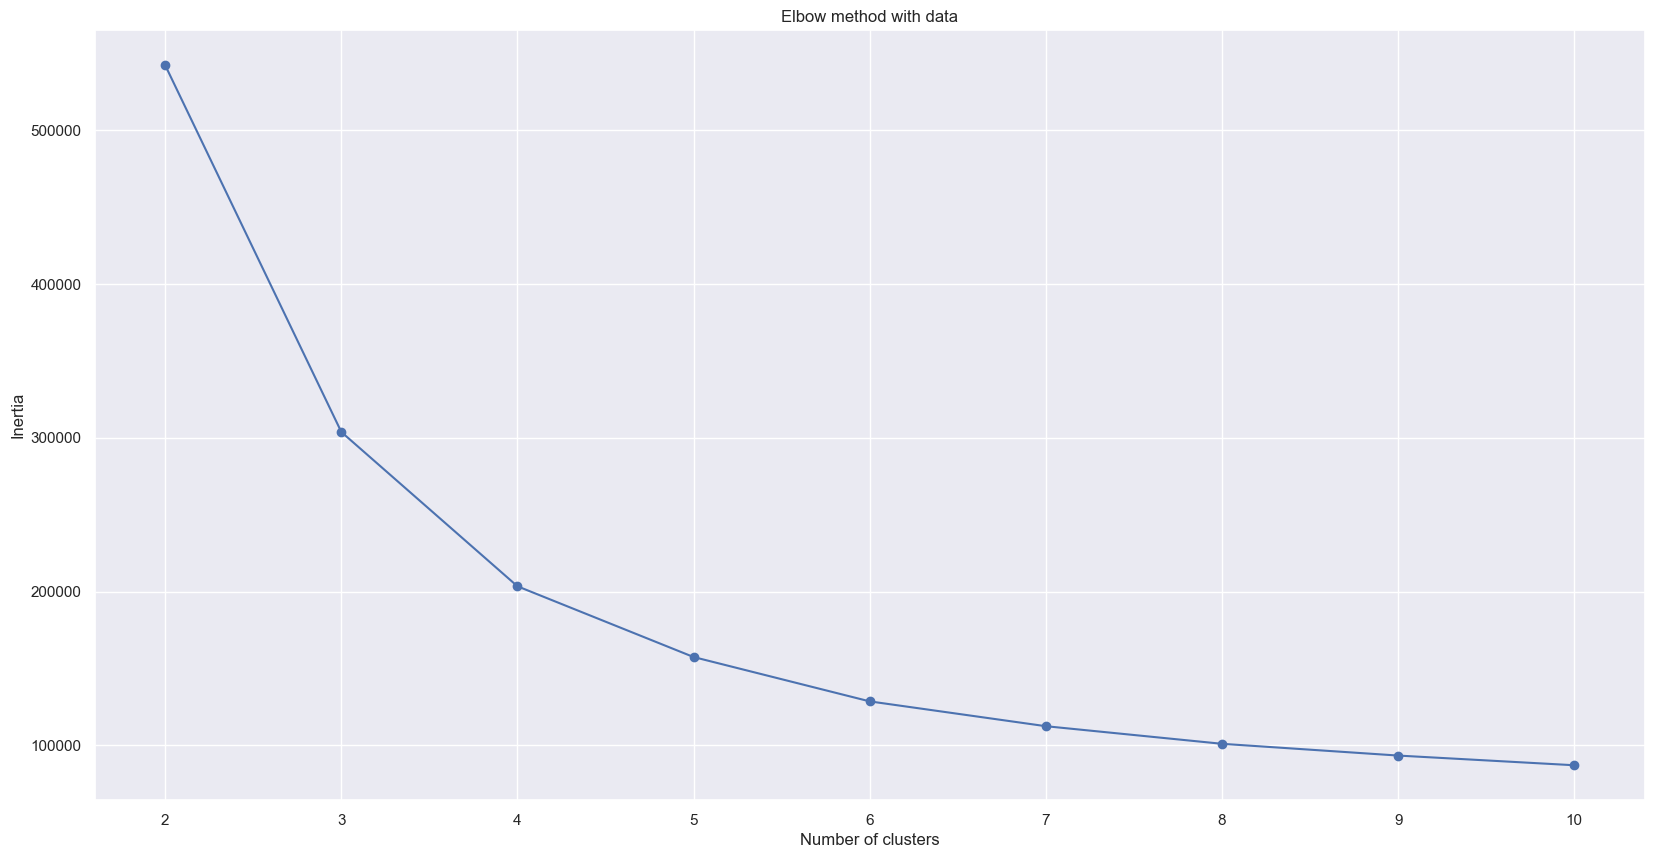

Лучшие параметры для KMeans: {'n_clusters': 2}
Лучший Silhouette Score для KMeans: 0.5182105393063701


In [29]:
# Sklearn KMeans

# Генерация списка возможных значений для n_clusters
param_grid = {'n_clusters': range(2, 11)}
best_score = -1
best_params = None
inertias = []

for params in ParameterGrid(param_grid):
    model = SklearnKMeans(**params, random_state=42).fit(x)
    score = silhouette_score(x, model.labels_)
    inertias.append(model.inertia_)
    if score > best_score:
        best_score = score
        best_params = params
print("inertia = " ,inertias )
plt.plot(range(2,11), inertias, marker='o')
plt.title('Elbow method with data')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

print(f"Лучшие параметры для KMeans: {best_params}")
print(f"Лучший Silhouette Score для KMeans: {best_score}")

In [30]:
!pip install kneed

### автоматический выбор количества кластеров для K-means, используя метод "локтя"

In [31]:
from kneed import KneeLocator
kneedle = KneeLocator(range(2,11), inertias , curve = "convex" , direction = "decreasing")
kneedle.elbow

4

## k = 4 - число кластеров

In [32]:
start_time = time.time()
sklearn_kmeans = SklearnKMeans(n_clusters=4, random_state=42)
sklearn_kmeans.fit(x)
print(f"Sklearn KMeans время обучения: {time.time() - start_time} секунд")
print(f"Sklearn KMeans Silhouette Score: {silhouette_score(x, sklearn_kmeans.labels_)}")

print(sklearn_kmeans.inertia_)
print(sklearn_kmeans.labels_)
print(set(list(sklearn_kmeans.labels_)))


Sklearn KMeans время обучения: 0.15457391738891602 секунд
Sklearn KMeans Silhouette Score: 0.4125064731306137
203440.40970730814
[3 0 1 ... 0 0 2]
{0, 1, 2, 3}


In [33]:
len(sklearn_kmeans.labels_)

6181

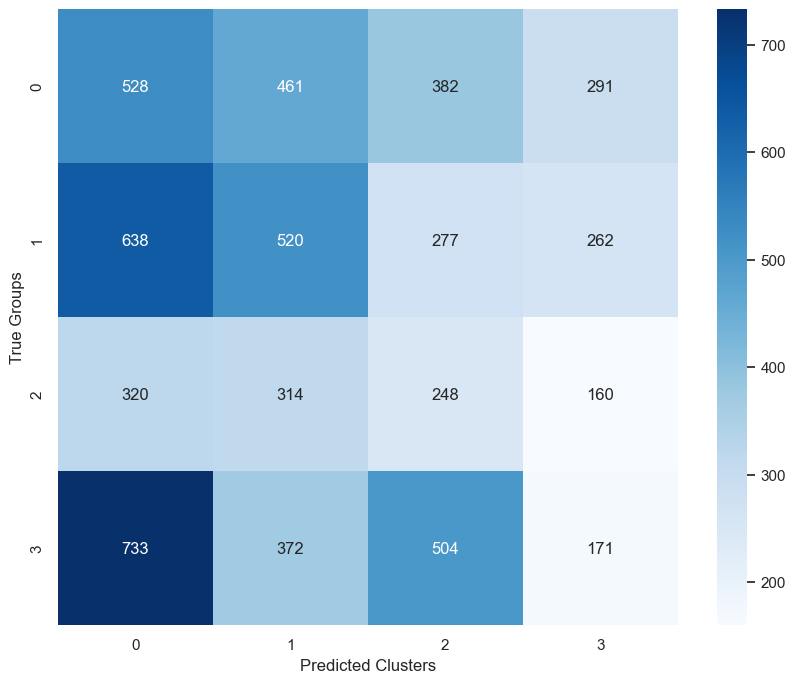

In [34]:
conf_matrix = confusion_matrix(y, sklearn_kmeans.labels_)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Groups')
plt.show()

Результат кластеризации не соответствует исходной структуре групп.

In [35]:
ari = adjusted_rand_score(y, sklearn_kmeans.labels_)
ami = adjusted_mutual_info_score(y, sklearn_kmeans.labels_)
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, sklearn_kmeans.labels_)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Adjusted Mutual Information: {ami:.4f}")
print(f"Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

Adjusted Rand Index: 0.0100
Adjusted Mutual Information: 0.0097
Homogeneity: 0.0101, Completeness: 0.0104, V-measure: 0.0102


### DBSCAN - не показал результатов

In [36]:
# DBSCAN
scaler = StandardScaler()
x_sc = scaler.fit_transform(x)

eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(2, 10)
best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples).fit(x_sc)
        labels = model.labels_
        
        # Фильтруем шумовые метки (-1)
        labels_filtered = labels[labels != -1]
        
        # Проверяем, есть ли минимум два кластера (без шума)
        if len(set(labels_filtered)) >= 2:
            score = silhouette_score(x_sc[labels != -1], labels_filtered)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
        else:
            print(f"DBSCAN с eps={eps} и min_samples={min_samples} не сформировал достаточно кластеров.")

if best_params:
    print(f"Лучшие параметры для DBSCAN: {best_params}")
    print(f"Лучший Silhouette Score для DBSCAN: {best_score}")
else:
    print("Не удалось найти подходящие параметры для DBSCAN.")

DBSCAN с eps=0.1 и min_samples=5 не сформировал достаточно кластеров.
DBSCAN с eps=0.1 и min_samples=6 не сформировал достаточно кластеров.
DBSCAN с eps=0.1 и min_samples=7 не сформировал достаточно кластеров.
DBSCAN с eps=0.1 и min_samples=8 не сформировал достаточно кластеров.
DBSCAN с eps=0.1 и min_samples=9 не сформировал достаточно кластеров.
DBSCAN с eps=0.2 и min_samples=5 не сформировал достаточно кластеров.
DBSCAN с eps=0.2 и min_samples=6 не сформировал достаточно кластеров.
DBSCAN с eps=0.2 и min_samples=7 не сформировал достаточно кластеров.
DBSCAN с eps=0.2 и min_samples=8 не сформировал достаточно кластеров.
DBSCAN с eps=0.2 и min_samples=9 не сформировал достаточно кластеров.
DBSCAN с eps=0.30000000000000004 и min_samples=5 не сформировал достаточно кластеров.
DBSCAN с eps=0.30000000000000004 и min_samples=6 не сформировал достаточно кластеров.
DBSCAN с eps=0.30000000000000004 и min_samples=7 не сформировал достаточно кластеров.
DBSCAN с eps=0.30000000000000004 и min_sam

In [37]:
# Вычисление матрицы сходства (в данном случае используется евклидово расстояние, преобразованное в сходство)
similarities = -euclidean_distances(x)
preference_median = np.median(similarities)


preference_mean = np.mean(similarities)
preference_mean

-17.9261

### Affinity Propagation не показал эффективность так как с увеличением Preference колличество кластеров увеличивалось

In [39]:
# Affinity Propagation
for pref in [preference_median + delta for delta in np.linspace(-5, 5, 5)]:
    ap = AffinityPropagation(damping=0.9, preference=pref, random_state=42)
    ap.fit(x)
    n_clusters = len(np.unique(ap.labels_))
    print(f"Preference: {pref:.2f}, Количество кластеров: {n_clusters}")

Preference: -19.76, Количество кластеров: 571
Preference: -18.76, Количество кластеров: 633
Preference: -17.76, Количество кластеров: 690
Preference: -16.76, Количество кластеров: 758
Preference: -15.76, Количество кластеров: 875


KeyboardInterrupt: 

Silhouette Score демонстрирует наилучшее значение при использовании 2 кластеров и 2 компонент, метрики ARI, Homogeneity, Completeness и V-measure остаются относительно низкими на протяжении всех испытаний. Метрики указывают на недостаточное соответствие между выявленной и ожидаемой структурой данных.

In [40]:
# Диапазон количества главных компонент для исследования
n_components_range = range(2, 21)

best_score = -1
best_params = {'n_clusters': None, 'n_components': None}
cluster_count_range = range(2, 10)

for n_cl in cluster_count_range:
    for n_components in n_components_range:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(x)
    
        kmeans = KMeans(n_clusters=n_cl)
        kmeans.fit(X_pca)
        score = silhouette_score(X_pca, kmeans.labels)

        # Вычисляем метрики
        ari = adjusted_rand_score(y, kmeans.labels)
        homogeneity = homogeneity_score(y, kmeans.labels)
        completeness = completeness_score(y, kmeans.labels)
        v_measure = v_measure_score(y, kmeans.labels)

        if score > best_score:
            best_score = score
            best_params['n_clusters'] = n_cl
            best_params['n_components'] = n_components
    
        print(f"Кластеры: {n_cl}, Компоненты: {n_components}, Silhouette Score: {score:.4f}, ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

print(f"Лучшие параметры: {best_params}, лучший Silhouette Score: {best_score:.4f}")

Кластеры: 2, Компоненты: 2, Silhouette Score: 0.5600, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 3, Silhouette Score: 0.5576, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 4, Silhouette Score: 0.5551, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 5, Silhouette Score: 0.5530, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 6, Silhouette Score: 0.5511, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 7, Silhouette Score: 0.5494, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 8, Silhouette Score: 0.5478, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 9, Silhouette Score: 0.5463, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.

Для SklearnKMeans результат аналогичный.

In [42]:
# Диапазон количества главных компонент для исследования
n_components_range = range(2, 21)

best_score = -1
best_params = {'n_clusters': None, 'n_components': None}
cluster_count_range = range(2, 10)

for n_cl in cluster_count_range:
    for n_components in n_components_range:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(x)
    
        model = SklearnKMeans(n_cl, random_state=42).fit(X_pca)
        score = silhouette_score(X_pca, model.labels_)

        # Вычисляем метрики
        ari = adjusted_rand_score(y, model.labels_)
        homogeneity = homogeneity_score(y, model.labels_)
        completeness = completeness_score(y, model.labels_)
        v_measure = v_measure_score(y, model.labels_)

        if score > best_score:
            best_score = score
            best_params['n_clusters'] = n_cl
            best_params['n_components'] = n_components
    
        print(f"Кластеры: {n_cl}, Компоненты: {n_components}, Silhouette Score: {score:.4f}, ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

print(f"Лучшие параметры: {best_params}, лучший Silhouette Score: {best_score:.4f}")

Кластеры: 2, Компоненты: 2, Silhouette Score: 0.5600, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 3, Silhouette Score: 0.5576, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.0143, V-measure: 0.0094
Кластеры: 2, Компоненты: 4, Silhouette Score: 0.5582, ARI: 0.0114, Homogeneity: 0.0071, Completeness: 0.0149, V-measure: 0.0096
Кластеры: 2, Компоненты: 5, Silhouette Score: 0.5561, ARI: 0.0114, Homogeneity: 0.0071, Completeness: 0.0149, V-measure: 0.0096
Кластеры: 2, Компоненты: 6, Silhouette Score: 0.5543, ARI: 0.0114, Homogeneity: 0.0071, Completeness: 0.0149, V-measure: 0.0096
Кластеры: 2, Компоненты: 7, Silhouette Score: 0.5526, ARI: 0.0114, Homogeneity: 0.0071, Completeness: 0.0149, V-measure: 0.0096
Кластеры: 2, Компоненты: 8, Silhouette Score: 0.5510, ARI: 0.0114, Homogeneity: 0.0071, Completeness: 0.0149, V-measure: 0.0096
Кластеры: 2, Компоненты: 9, Silhouette Score: 0.5463, ARI: 0.0112, Homogeneity: 0.0070, Completeness: 0.

In [77]:
# Функция 2D визуализации
def plot_2d_clusters(X, labels, title='2D Projection'):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1:  # для визуализации шума (DBSCAN)
            color = 'k'
        else:
            color = plt.cm.jet(float(label) / np.max(unique_labels + 1))
        plt.scatter(X[labels == label, 0], X[labels == label, 1], c=[color], label=f'Cluster {label}')
    plt.title(title)
    plt.xlabel('1')
    plt.ylabel('2')
    plt.legend()
    plt.show()

In [78]:
# Функция 3D визуализации
def plot_3d_clusters(X, labels, title='3D Projection'):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Визуализация данных с окраской по меткам кластеров
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', alpha=0.5)
    ax.view_init(azim=75)

    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_xlabel("1")
    ax.set_ylabel("2")
    ax.set_zlabel("3")
    plt.title(title)
    plt.show()

### Применение PCA для снижения размерности до 2 и 3.

In [45]:
# Снижение размерности до 2D с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

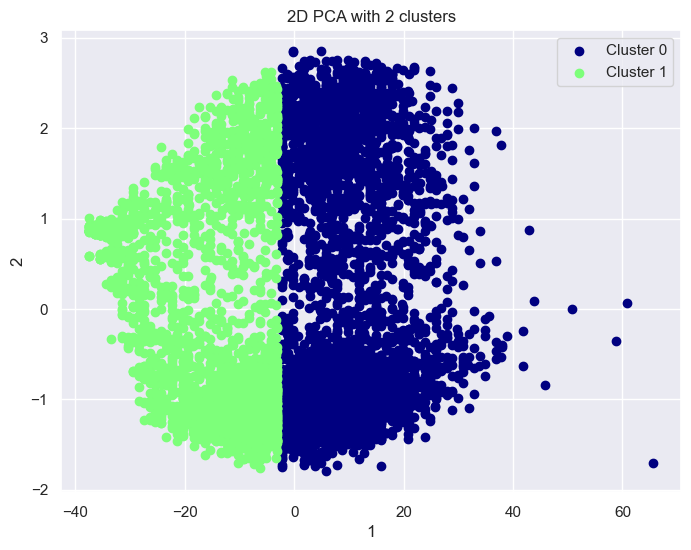

In [84]:
# 2D визуализация для моей реализации K-means с 2 кластерами
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

plot_2d_clusters(X_pca, kmeans.labels, '2D PCA with 2 clusters')

Данные разделены линией, которая кажется параллельной оси PCA2. Это может указывать на то, что первая главная компонента (PCA1) имеет значительное влияние на разделение данных на кластеры, т. е. вариабельность данных по этой компоненте наиболее значительна для определения принадлежности к определенному кластеру.

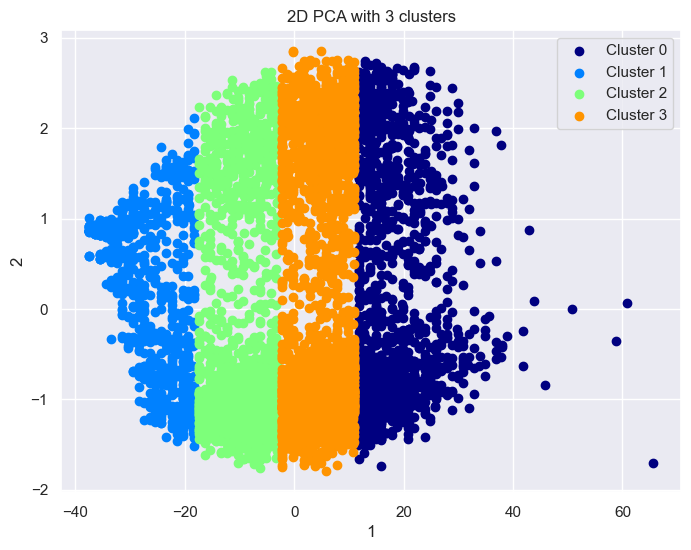

In [85]:
# 2D визуализация для моей реализации K-means с 4 кластерами
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)

plot_2d_clusters(X_pca, kmeans.labels, '2D PCA with 3 clusters')

In [51]:
# Снижение размерности до 3D с помощью PCA
pca3= PCA(n_components=3)
X_pca_3 = pca3.fit_transform(x)

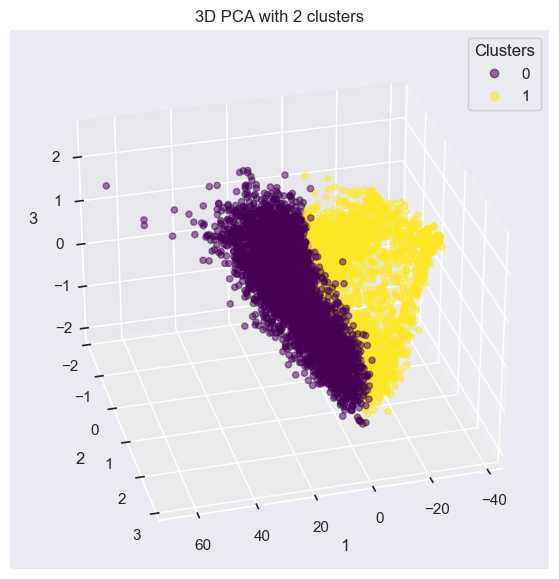

In [86]:
# 3D визуализация для моей реализации K-means с 2 кластерами
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

plot_3d_clusters(X_pca_3, kmeans.labels, '3D PCA with 2 clusters')

Кластеры имеют форму двух отдельных облаков точек, что может указывать на хорошую разделимость в данных, особенно вдоль оси PCA 1.

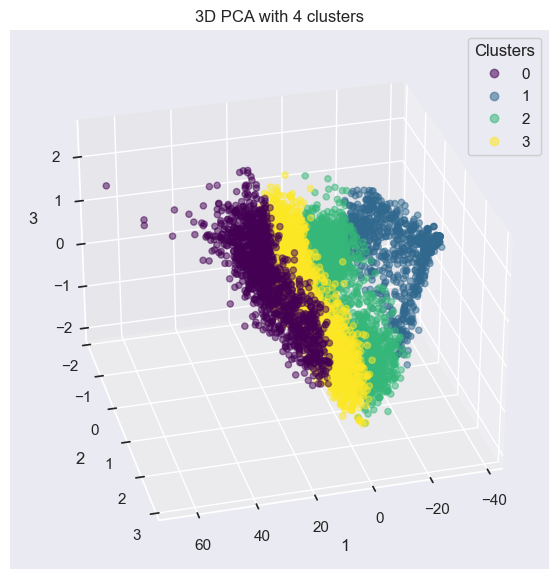

In [87]:
# 3D визуализация для моей реализации K-means с 4 кластерами
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)

plot_3d_clusters(X_pca_3, kmeans.labels, '3D PCA with 4 clusters')

### Применение t-SNE для снижения размерности

Сперва применим для PCA уменьшения размерности до 50

In [66]:
pca_50 = PCA(n_components=50)
X_pca_50 = pca.fit_transform(x)

In [71]:
tsne_2 = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne_2 = tsne_2.fit_transform(X_pca_50)

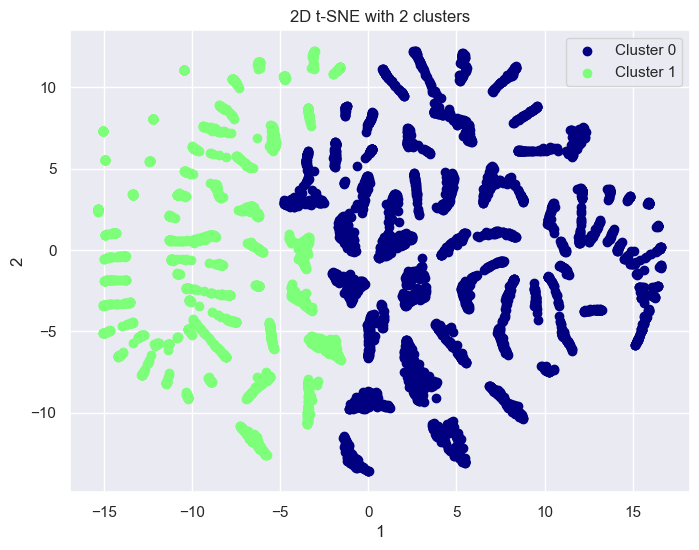

In [88]:
# 2D визуализация для моей реализации K-means с 2 кластерами после t-SNE
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

plot_2d_clusters(X_tsne_2, kmeans.labels, '2D t-SNE with 2 clusters')

Полученные кластеры имеют значительно более сложную структуру по сравнению с результатами PCA. Данные так же хорошо разделены вдоль оси PCA 1.

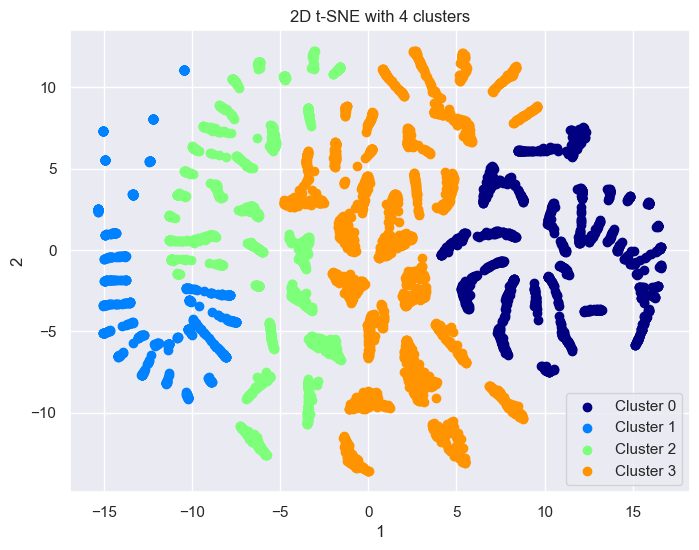

In [89]:
# 2D визуализация для моей реализации K-means с 4 кластерами после t-SNE
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)

plot_2d_clusters(X_tsne_2, kmeans.labels, '2D t-SNE with 4 clusters')

In [81]:
tsne_3 = TSNE(n_components=3, perplexity=30, n_iter=300)
X_tsne_3 = tsne_3.fit_transform(X_pca_50)

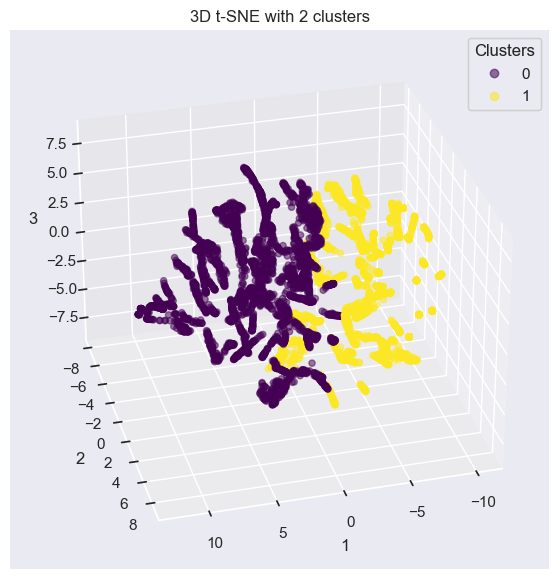

In [90]:
# 3D визуализация для моей реализации K-means с 2 кластерами после t-SNE
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)

plot_3d_clusters(X_tsne_3, kmeans.labels, '3D t-SNE with 2 clusters')

Каждый кластер образует своё собственное облако точек, что указывает на различие в распределении данных между кластерами.

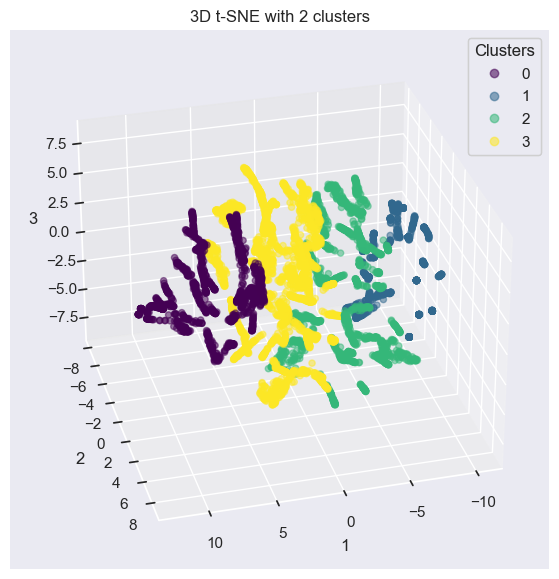

In [91]:
# 3D визуализация для моей реализации K-means с 4 кластерами после t-SNE
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)

plot_3d_clusters(X_tsne_3, kmeans.labels, '3D t-SNE with 2 clusters')